In [1]:
#COLAB
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:

#STYLE TRANSFER - GATYS ORIGINAL OPEN SOURCE
#FROM GITHUB https://github.com/rrmina/neural-style-pytorch

#DOWNLOAD MODEL
!gdown --id 18iZOwjrkTHm7PDf796LvI89IMLh0-_uE -q

In [3]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image


#DEVICE
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
#PARAMETERS

OPTIMIZER = 'lbfgs' 
ADAM_LR = 10
CONTENT_WEIGHT = 5e0
STYLE_WEIGHT = 1e6 
TV_WEIGHT = 1e-3
NUM_ITER = 100
SHOW_ITER = 20
POOL = 'avg'

#IMAGES
INIT_IMAGE = 'content' # 'random' or 'content'
PRESERVE_COLOR = 'False' # 'False'
PIXEL_CLIP = 'True' # or 'False' - Clipping produces better images


MAX_IMAGE_SIZE = 840 
CONTENT_PATH = '/content/gdrive/My Drive/AiPainter/images/content/avril.jpg'
STYLE_PATH = '/content/gdrive/My Drive/AiPainter/images/style/la_muse.jpg'
OUT_PATH = '/content/gdrive/My Drive/AiPainter/images/results/avril_la_muse_original.jpg'

print(OUT_PATH)

"""
PRETRAINED VGG MODELS 
GITHUB REPO: https://github.com/jcjohnson/pytorch-vgg
VGG 19: https://web.eecs.umich.edu/~justincj/models/vgg19-d01eb7cb.pth
VGG 16: https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth
"""

VGG19_PATH = 'vgg19-d01eb7cb.pth'


/content/gdrive/My Drive/AiPainter/images/results/avril_la_muse_original.jpg


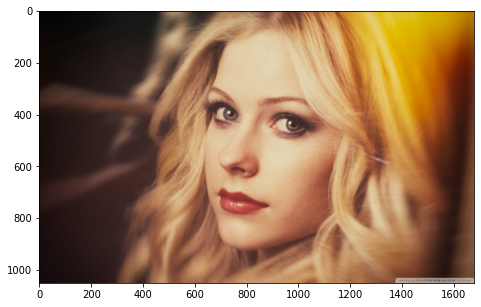

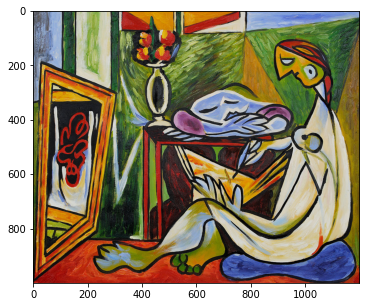

In [5]:
#UTILS
def load_image(path):
    # Images loaded as BGR
    img = cv2.imread(path)
    return img

def show(img):
    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # imshow() only accepts float [0,1] or int [0,255]
    img = np.array(img/255).clip(0,1)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.show()
    
def saveimg(img, iters):
    if (PIXEL_CLIP=='True'):
        img = img.clip(0, 255)
    cv2.imwrite(OUT_PATH, img)
    
def transfer_color(src, dest):
    if (PIXEL_CLIP=='True'):
        src, dest = src.clip(0,255), dest.clip(0,255)
        
    # Resize src to dest's size
    H,W,_ = src.shape 
    dest = cv2.resize(dest, dsize=(W, H), interpolation=cv2.INTER_CUBIC)
    
    dest_gray = cv2.cvtColor(dest, cv2.COLOR_BGR2GRAY) #1 Extract the Destination's luminance
    src_yiq = cv2.cvtColor(src, cv2.COLOR_BGR2YCrCb)   #2 Convert the Source from BGR to YIQ/YCbCr
    src_yiq[...,0] = dest_gray                         #3 Combine Destination's luminance and Source's IQ/CbCr
    
    return cv2.cvtColor(src_yiq, cv2.COLOR_YCrCb2BGR)  #4 Convert new image from YIQ back to BGR


#PREPROCESS
def itot(img):
    # Rescale the image
    H, W, C = img.shape
    image_size = tuple([int((float(MAX_IMAGE_SIZE) / max([H,W]))*x) for x in [H, W]])
    
    itot_t = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    
    # Subtract the means
    normalize_t = transforms.Normalize([103.939, 116.779, 123.68],[1,1,1])
    tensor = normalize_t(itot_t(img)*255)
    
    # Add the batch_size dimension
    tensor = tensor.unsqueeze(dim=0)
    return tensor

def ttoi(tensor):
    # Add the means
    ttoi_t = transforms.Compose([
        transforms.Normalize([-103.939, -116.779, -123.68],[1,1,1])])
    
    # Remove the batch_size dimension
    tensor = tensor.squeeze()
    img = ttoi_t(tensor)
    img = img.cpu().numpy()
    
    # Transpose from [C, H, W] -> [H, W, C]
    img = img.transpose(1, 2, 0)
    return img


#LOAD IMAGES
content_img = load_image(CONTENT_PATH)
style_img = load_image(STYLE_PATH)    

#DISPLAY
show(content_img)
show(style_img)


#LOAD VGG19 STRUCTURE
vgg = models.vgg19(pretrained=False)

#LOAD WEIGHTS
vgg.load_state_dict(torch.load(VGG19_PATH), strict=False)

#CHANGE POOLING 
def pool_(model, pool='avg'):
    if (pool=='avg'):
        ct=0
        for layer in model.children():
            if isinstance(layer, nn.MaxPool2d):
                model[ct] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
            ct+=1
    elif (pool=='max'):
        ct=0
        for layer in model.children():
            if isinstance(layer, nn.AvgPool2d):
                model[ct] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            ct+=1
            
    return model

vgg.features = pool_(vgg.features, POOL)

# Extract only the 'features' network, 
# 'classifier' network is not needed
model = copy.deepcopy(vgg.features)
model.to(device)
#print(model)

# Turn-off unnecessary gradient tracking
for param in model.parameters():
    param.requires_grad = False


mse_loss = torch.nn.MSELoss()
def gram(tensor):
    B, C, H, W = tensor.shape
    x = tensor.view(C, H*W)
    return torch.mm(x, x.t())

def content_loss(g, c):
    loss = mse_loss(g, c)
    return loss
    
def style_loss(g, s):
    c1,c2 = g.shape
    loss = mse_loss(g, s)
    return loss / (c1**2) # Divide by square of channels

def tv_loss(c):
    x = c[:,:,1:,:] - c[:,:,:-1,:]
    y = c[:,:,:,1:] - c[:,:,:,:-1]
    loss = torch.sum(torch.abs(x)) + torch.sum(torch.abs(y))
    return loss



# VGG Forward Pass
def get_features(model, tensor):
    layers = {
        '3': 'relu1_2',   # Style layers
        '8': 'relu2_2',
        '11' : 'relu3_3',
        '20' : 'relu4_3',
        '29' : 'relu5_3',
        '22' : 'relu4_2', # Content layers
        #'31' : 'relu5_2'
    }

    #CHANGE TO 1.1 2.1 3.1 4.1 5.1
    layers = {
        '1': 'relu1_2',   # Style layers
        '6': 'relu2_2',
        '17' : 'relu3_3',
        '26' : 'relu4_3',
        '35' : 'relu5_3',
        '22' : 'relu4_2', # Content layers
        #'31' : 'relu5_2'
    }
    
    # Get features
    features = {}
    x = tensor
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            if (name=='22'):   # relu4_2
                features[layers[name]] = x
            elif (name=='31'): # relu5_2
                features[layers[name]] = x
            else:
                b, c, h, w = x.shape
                features[layers[name]] = gram(x) / (h*w)
                
            # Terminate forward pass
            if (name == '35'):
                break
            
    return features


# Generate Initial Image
def initial(content_tensor, init_image='random'):
    B, C, H, W = content_tensor.shape
    if (init_image=='random'):
        #tensor = torch.randn(C, H, W).mul(torch.std(content_tensor.clone().cpu())/255).unsqueeze(0)
        tensor = torch.randn(C, H, W).mul(0.001).unsqueeze(0)
    else:
        tensor = content_tensor.clone().detach()
    
    return tensor

# Convert Images to Tensor
content_tensor = itot(content_img).to(device)
style_tensor = itot(style_img).to(device)
g = initial(content_tensor, init_image=INIT_IMAGE)
g = g.to(device).requires_grad_(True)


def stylize(iteration=NUM_ITER):     
    # Get features representations/Forward pass
    content_layers = ['relu4_2']
    content_weights = {'relu4_2': 1.0} 
    style_layers = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3']
    style_weights = {'relu1_2': 0.2, 'relu2_2': 0.2, 'relu3_3': 0.2, 'relu4_3': 0.2, 'relu5_3': 0.2}
    c_feat = get_features(model, content_tensor)
    s_feat = get_features(model, style_tensor)
    
    i = [0]
    while i[0] < iteration:
        def closure():
            # Zero-out gradients
            optimizer.zero_grad()

            # Forward pass
            g_feat = get_features(model, g)

            # Compute Losses
            c_loss=0
            s_loss=0
            for j in content_layers:
                c_loss += content_weights[j] * content_loss(g_feat[j], c_feat[j])
            for j in style_layers:
                s_loss += style_weights[j] * style_loss(g_feat[j], s_feat[j])
            
            c_loss = CONTENT_WEIGHT * c_loss
            s_loss = STYLE_WEIGHT * s_loss
            t_loss = TV_WEIGHT * tv_loss(g.clone().detach())
            total_loss = c_loss + s_loss + t_loss

            # Backprop
            total_loss.backward(retain_graph=True)
          
            # Print Loss, show and save image
            i[0]+=1
            
            if (((i[0] % SHOW_ITER) == 0) or (i[0]==NUM_ITER)):
                print("Style Loss: {} Content Loss: {} TV Loss: {} Total Loss : {}".format(s_loss.item(), c_loss.item(), t_loss, total_loss.item()))
                print("Epoch: {}".format(i[0]))
                if (PRESERVE_COLOR=='True'):
                    g_ = transfer_color(ttoi(content_tensor.clone().detach()), ttoi(g.clone().detach()))
                else:
                    g_ = ttoi(g.clone().detach())
                show(g_)

                #OLD BUG here when commented out!
                #saveimg(g_, i[0])
                plt.show()
            
            return (total_loss)
        
        # Weight/Pixel update
        optimizer.step(closure)

    return g

if (OPTIMIZER=='lbfgs'):
    optimizer = optim.LBFGS([g])
elif (OPTIMIZER=='adam'):
    optimizer = optim.Adam([g], lr=ADAM_LR)
    



In [6]:
# Stylize!
out = stylize(iteration=NUM_ITER)

show(content_img) # Original Content

show(ttoi(g.clone().detach())) # Style Transfer
saveimg(ttoi(g.clone().detach()), NUM_ITER)

if (PRESERVE_COLOR=='True'):
    c_clone = ttoi(content_tensor.clone().detach())
    g_clone = ttoi(g.clone().detach())
    g_preserve = transfer_color(c_clone, g_clone) # Style Transfer + Preserve original color
    show(g_preserve)
    saveimg(g_preserve, 333) # out333 = final with preserved colors

Output hidden; open in https://colab.research.google.com to view.